In [52]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

'''import kagglehub
borismarjanovic_price_volume_data_for_all_us_stocks_etfs_path = kagglehub.dataset_download('borismarjanovic/price-volume-data-for-all-us-stocks-etfs')
print('Data source import complete.')'''

"import kagglehub\nborismarjanovic_price_volume_data_for_all_us_stocks_etfs_path = kagglehub.dataset_download('borismarjanovic/price-volume-data-for-all-us-stocks-etfs')\nprint('Data source import complete.')"

### Introduction

In this kernel I use XGBRegressor from XGBoost library to predict future prices of stocks using technical indicator as features. If you are looking for an explanation of indicators (e.g. moving averages, RSI, MACD) used below, please refer to [articles on Investopedia](https://www.investopedia.com/technical-analysis-4689657) or [this notebook of mine](https://www.kaggle.com/mtszkw/analysis-and-technical-indicators-for-trading-etfs) where I introduce and visualize various technical analysis concepts.

In [1]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

import yfinance as yf
import seaborn as sns
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    precision_score, recall_score, f1_score,
    precision_recall_curve, average_precision_score,
    roc_curve, roc_auc_score
)

import FinanceDataReader as fdr
from datetime import datetime
from alpha_code_1 import get_alpha
from sklearn.preprocessing import StandardScaler


# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

ModuleNotFoundError: No module named 'alpha_code_1'

### Read historical prices

I read historical data frame for a chosen stock (e.g. CERN) which I am going to analyze. New York Stock Exchange dataset provides day by day price history gathered over more than 10 years. I decided to crop the time frame and start it from a year 2010 to reduce amount of data to be processed.

Removing rows is then followed by reindexing the data frame to keep it clean.

In [ ]:
import FinanceDataReader as fdr

start_date = '2016-01-01'
end_date = '2020-12-31'

df = fdr.DataReader('KS11', start_date, end_date)
df = df.reset_index()

# 다음날 종가가 오늘보다 높으면 1 (상승), 아니면 0 (하락)
df['target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

df = df.rename(columns={
    "Open": "S_DQ_OPEN", 
    "High": "S_DQ_HIGH", 
    "Low": "S_DQ_LOW", 
    "Change":"S_DQ_PCTCHANGE",
    "Close": "S_DQ_CLOSE", 
    "Volume": "S_DQ_VOLUME", 
    "Amount":"S_DQ_AMOUNT"
})

df['Date'] = pd.to_datetime(df['Date'])
df.index = range(len(df))
df = get_alpha(df)

# 마지막 row는 타겟이 없으므로 제거
df = df.iloc[:-1]

In [ ]:
# 1. 결측값 채우기 (forward fill → backward fill → 0 대체)
def fill_missing(df):
    df = df.replace([np.inf, -np.inf], 0)
    df = df.fillna(method='ffill')
    df = df.fillna(method='bfill')
    df = df.fillna(0)
    return df

# 2. 정규화 (표준화: 평균 0, 표준편차 1)
def normalize(df):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df)
    return pd.DataFrame(scaled, index=df.index, columns=df.columns)

# 3. 이산형 / 연속형 분리
def separate_discrete_continuous(df, threshold=10):
    discrete_features = []
    continuous_features = []
    for col in df.columns:
        unique_values = df[col].nunique()
        if unique_values <= threshold:
            discrete_features.append(col)
        else:
            continuous_features.append(col)
    return discrete_features, continuous_features

# 4. 중복 feature 제거 (feature 값이 거의 비슷한 경우 제거)
def remove_duplicate_features(df, duplicate_threshold=0.2):
    to_remove = []
    for col in df.columns:
        freq = df[col].value_counts(normalize=True).max()
        if freq > duplicate_threshold:
            to_remove.append(col)
    df_cleaned = df.drop(columns=to_remove)
    return df_cleaned, to_remove


# 5. 전체 파이프라인 함수
def clean_features(df):
    print("원본 feature 수:", df.shape[1])

    # 결측값 채우기
    df = fill_missing(df)
    print("결측값 채우기 완료")

    # 정규화
    df = normalize(df)
    print("정규화 완료")

    # 이산형/연속형 분리
    discrete_features, continuous_features = separate_discrete_continuous(df)
    print(f"이산형 feature 수: {len(discrete_features)}, 연속형 feature 수: {len(continuous_features)}")

    # 중복 feature 제거
    df_cleaned, removed_features = remove_duplicate_features(df)
    print(f"중복 feature 제거 완료 (제거한 feature 수: {len(removed_features)})")

    print("최종 feature 수:", df_cleaned.shape[1])
    return df_cleaned, discrete_features, continuous_features, removed_features

# S_DQ_ 로 시작하는 원본 칼럼들은 제외하고 알파만 선택
alpha_cols = [col for col in df.columns if col.startswith('alpha')]
df_alphas_only = df[alpha_cols]

# 파이프라인 적용
df_cleaned, discrete_features, continuous_features, removed_features = clean_features(df_alphas_only)

# 1. 상관 높은 feature 제거 함수
def remove_highly_correlated_features(df, correlation_threshold=0.99):
    corr_matrix = df.corr().abs()  # 절댓값 상관계수 계산
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]
    
    df_cleaned = df.drop(columns=to_drop)
    
    return df_cleaned, to_drop

# 1. 상관 높은 feature 제거
df_uncorrelated, dropped_corr_features = remove_highly_correlated_features(df_cleaned, correlation_threshold=0.99)

print(f"상관 관계로 제거한 feature 수: {len(dropped_corr_features)}")

### OHLC Chart

I start with drawing an OHLC (open/high/low/close) chart to get a sense of historical prices. Below OHLC I draw Volume chart which shows number of stocks traded each day. In my previous notebook (linked above) I explain importance of OHLC and Volume charts in technical analysis.

In [55]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

### Decomposition

In [56]:
'''df_close = df[['Date', 'Close']].copy()
df_close = df_close.set_index('Date')
df_close.head()

decomp = decompose(df_close, period=365)
fig = decomp.plot()
fig.set_size_inches(20, 8)'''

"df_close = df[['Date', 'Close']].copy()\ndf_close = df_close.set_index('Date')\ndf_close.head()\n\ndecomp = decompose(df_close, period=365)\nfig = decomp.plot()\nfig.set_size_inches(20, 8)"

### Technical indicators

#### Moving Averages

I'm calculating few moving averages to be used as features: $SMA_{5}$, $SMA_{10}$, $SMA_{15}$, $SMA_{30}$ and $EMA_{9}$.

In [57]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', opacity=0.2))
fig.show()

#### Relative Strength Index

I'll add RSI indicator to predict whether a stock is overbought/oversold.

In [58]:
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

#### MACD

In [59]:
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

### Shift label column

Because I want to predict the next day price, after calculating all features for day $D_{i}$, I shift Close price column by -1 rows. After doing that, for day $D_{i}$ we have features from the same timestamp e.g. $RSI_{i}$, but the price $C_{i+1}$ from upcoming day.

In [60]:
df['Close'] = df['Close'].shift(-1)

### Drop invalid samples

Because of calculating moving averages and shifting label column, few rows will have invalid values i.e. we haven't calculated $SMA_{10}$ for the first 10 days. Moreover, after shifting Close price column, last row price is equal to 0 which is not true. Removing these samples should help.

In [61]:
df = df.iloc[33:] # Because of moving averages and MACD line
df.index = range(len(df))

Here I split stock data frame into three subsets: training ($70\%$), validation ($15\%$) and test ($15\%$) sets. I calculated split indices and create three separate frames (train_df, valid_df, test_df). All three frames have been ploted in the chart below.

In [62]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
fig.show()

### Drop unnecessary columns

In [63]:
features = ['EMA_9','SMA_5','SMA_10','SMA_15','SMA_30','RSI','MACD','MACD_signal','target']

train_df = train_df[features]
valid_df = valid_df[features]
test_df = test_df[features]

### Split into features and labels

In [64]:
y_train = train_df['target'].copy()
X_train = train_df.drop(['target'], 1)

y_valid = valid_df['target'].copy()
X_valid = valid_df.drop(['target'], 1)

y_test  = test_df['target'].copy()
X_test  = test_df.drop(['target'], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836 entries, 0 to 835
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EMA_9        836 non-null    float64
 1   SMA_5        836 non-null    float64
 2   SMA_10       836 non-null    float64
 3   SMA_15       836 non-null    float64
 4   SMA_30       836 non-null    float64
 5   RSI          836 non-null    float64
 6   MACD         836 non-null    float64
 7   MACD_signal  836 non-null    float64
dtypes: float64(8)
memory usage: 52.4 KB


### Fine-tune XGBoostRegressor

In [65]:
%%time
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

parameters = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05],
    'max_depth': [8, 10],
    'gamma': [0.001, 0.01],
    'random_state': [42]
}

model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
clf = GridSearchCV(model, parameters, scoring='accuracy', cv=tscv)
clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation accuracy = {clf.best_score_:.4f}')

c:\Users\minju\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning:

[15:04:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\minju\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning:

[15:04:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\minju\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning:

[15:04:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\minju\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning:

[15:04:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\minju\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning:

[15:04:57] WARNING: C:\actions-runner\_work\xgboost\xgboos

Best params: {'gamma': 0.001, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100, 'random_state': 42}
Best validation accuracy = 0.4993
CPU times: total: 2min 56s
Wall time: 13.1 s


c:\Users\minju\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning:

[15:05:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




In [66]:
%%time
model = xgb.XGBClassifier(
    **clf.best_params_,
    objective='binary:logistic',
    use_label_encoder=False,  # 경고 방지
    eval_metric='logloss'     # 또는 'error', 'auc' 등 선택 가능
)

model.fit(X_train, y_train)

CPU times: total: 2.12 s
Wall time: 187 ms


c:\Users\minju\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning:

[15:05:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.001,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

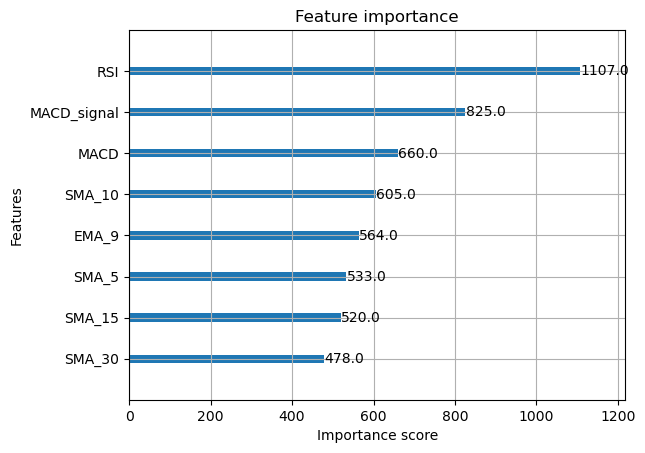

In [67]:
plot_importance(model);

### Calculate and visualize predictions

In [68]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [0 1 0 1 0]
y_pred = [1 1 1 1 1]


In [69]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.4943820224719101
              precision    recall  f1-score   support

           0       0.29      0.33      0.31        61
           1       0.62      0.58      0.60       117

    accuracy                           0.49       178
   macro avg       0.46      0.45      0.45       178
weighted avg       0.51      0.49      0.50       178

Confusion Matrix:
 [[20 41]
 [49 68]]


📊 성능 평가:
Accuracy: 0.4943820224719101
Precision: 0.6238532110091743
Recall: 0.5811965811965812
F1 Score: 0.6017699115044248
ROC-AUC: 0.4518004763906403

Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.33      0.31        61
           1       0.62      0.58      0.60       117

    accuracy                           0.49       178
   macro avg       0.46      0.45      0.45       178
weighted avg       0.51      0.49      0.50       178



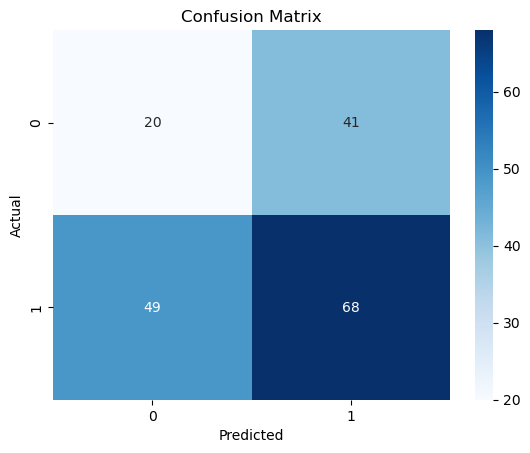

In [71]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix
)

# 예측 (클래스 레이블)
y_pred = model.predict(X_test)

# 예측 (확률)
y_proba = model.predict_proba(X_test)[:, 1]

# 기본 지표 출력
print("📊 성능 평가:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

# 요약 리포트
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 혼동 행렬
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Threshold=0.450 | Precision(1)=0.632 | Recall(1)=0.718 | Precision(0)=0.267 | Recall(0)=0.197 | Accuracy=0.539
Threshold=0.451 | Precision(1)=0.632 | Recall(1)=0.718 | Precision(0)=0.267 | Recall(0)=0.197 | Accuracy=0.539
Threshold=0.452 | Precision(1)=0.632 | Recall(1)=0.718 | Precision(0)=0.267 | Recall(0)=0.197 | Accuracy=0.539
Threshold=0.453 | Precision(1)=0.632 | Recall(1)=0.718 | Precision(0)=0.267 | Recall(0)=0.197 | Accuracy=0.539
Threshold=0.454 | Precision(1)=0.632 | Recall(1)=0.718 | Precision(0)=0.267 | Recall(0)=0.197 | Accuracy=0.539
Threshold=0.455 | Precision(1)=0.632 | Recall(1)=0.718 | Precision(0)=0.267 | Recall(0)=0.197 | Accuracy=0.539
Threshold=0.456 | Precision(1)=0.632 | Recall(1)=0.718 | Precision(0)=0.267 | Recall(0)=0.197 | Accuracy=0.539
Threshold=0.457 | Precision(1)=0.632 | Recall(1)=0.718 | Precision(0)=0.267 | Recall(0)=0.197 | Accuracy=0.539
Threshold=0.458 | Precision(1)=0.629 | Recall(1)=0.709 | Precision(0)=0.261 | Recall(0)=0.197 | Accuracy=0.534
T

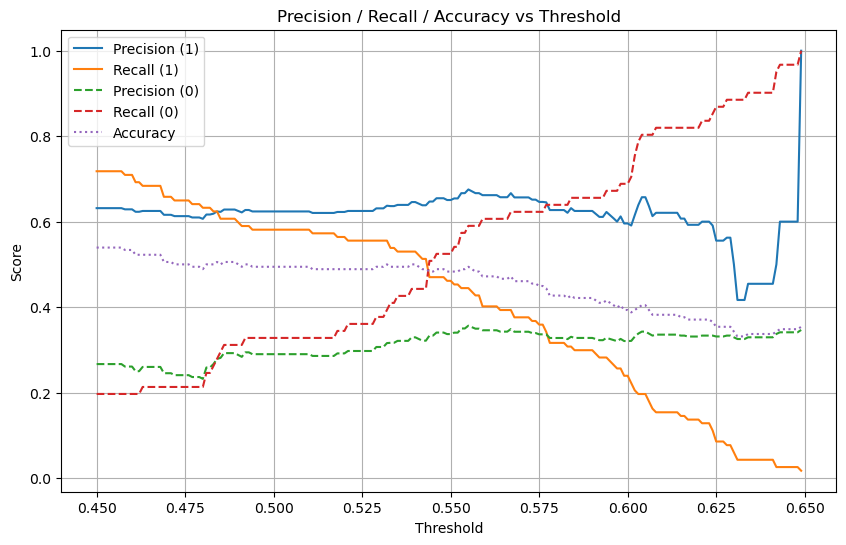

In [73]:
# 1. 확률 예측
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 2. threshold 리스트
thresholds = np.arange(0.45, 0.65, 0.001)

# 3. 저장할 리스트
precision_1_list = []
recall_1_list = []
precision_0_list = []
recall_0_list = []
accuracy_list = []

# 4. 각 threshold에 대해 계산
for threshold in thresholds:
    y_pred_custom = (y_pred_proba >= threshold).astype(int)

    precision_1 = precision_score(y_test, y_pred_custom, pos_label=1)
    recall_1 = recall_score(y_test, y_pred_custom, pos_label=1)
    precision_0 = precision_score(y_test, y_pred_custom, pos_label=0)
    recall_0 = recall_score(y_test, y_pred_custom, pos_label=0)
    accuracy = accuracy_score(y_test, y_pred_custom)

    precision_1_list.append(precision_1)
    recall_1_list.append(recall_1)
    precision_0_list.append(precision_0)
    recall_0_list.append(recall_0)
    accuracy_list.append(accuracy)

# 5. 결과 출력
for t, p1, r1, p0, r0, acc in zip(thresholds, precision_1_list, recall_1_list, precision_0_list, recall_0_list, accuracy_list):
    print(f"Threshold={t:.3f} | Precision(1)={p1:.3f} | Recall(1)={r1:.3f} | Precision(0)={p0:.3f} | Recall(0)={r0:.3f} | Accuracy={acc:.3f}")

# 6. 그래프 그리기
plt.figure(figsize=(10,6))
plt.plot(thresholds, precision_1_list, label='Precision (1)', linestyle='-')
plt.plot(thresholds, recall_1_list, label='Recall (1)', linestyle='-')
plt.plot(thresholds, precision_0_list, label='Precision (0)', linestyle='--')
plt.plot(thresholds, recall_0_list, label='Recall (0)', linestyle='--')
plt.plot(thresholds, accuracy_list, label='Accuracy', linestyle=':')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision / Recall / Accuracy vs Threshold')
plt.legend()
plt.grid(True)
plt.show()